<a href="https://colab.research.google.com/github/AlexeyRogS/cv_course/blob/week6/week6/vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

## ViT
<img src="https://i.ibb.co/3rz7cQP/Screenshot-116.png" width="800" height="350">

* Изображение разбиваем на патчи, каждый патч мапится с помощью линейного слоя (linear projectiont).
* Последовательность эмбедингов патчей пропускаем через энкодер трансформера (transformer encoder)
* Используем обучаемые позиционные эмбединги, также вводим "фиктивный" нулевой патч, на основе которого делаем итоговую классификацию. (positional embedding + class embedding)

In [16]:
class PatchPartitioner(nn.Module):
    # this class is used to transform batch of images (B, C, H, W) into
    # a batch of sequences of patches embeddings (B, H / k_h * W / k_w, k_h*k_w*C)
    def __init__(self, in_h, in_w, out_h, out_w, in_channels, embedding_dim):
        super(PatchPartitioner, self).__init__()
        assert in_h % out_h == 0 and in_w % out_w == 0 and in_h // out_h == in_w // out_w
        k_size = in_h // out_h

        # YOUR CODE HERE
        self.conv = nn.Conv2d(in_channels, embedding_dim, k_size, stride=k_size)

        self.flatten = nn.Flatten(2, 3)

    def forward(self, x):
        return self.flatten(self.conv(x)).transpose(1, 2)

In [17]:
pp = PatchPartitioner(in_h=32, in_w=32, out_h=16, out_w=16, in_channels=1, embedding_dim=100)
result = pp(torch.zeros((1, 1, 32, 32)))
assert result.shape == (1, 16*16, 100)

## MSA (multi head self-attention)

<img src="https://i.ibb.co/1q04DSF/Screenshot-151.png" width='150' height='300'>

* Энкодер состоит из слоя multi-head attention и mlp. Multi-head attention по сути объединяет вместе несколько простых attention слоев:\
$\text{MultiHead}(Q, K, V) = \text{Concat}(head_1,\dots,head_h)W^O$\
где $head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$\
$\text{Attention}(Q, K, V) = \text{Softmax}(\frac{QK^{T}}{\sqrt{d_k}})V$

* На практике часто (например [тут](https://github.com/microsoft/Swin-Transformer/blob/2cb103f2de145ff43bb9f6fc2ae8800c24ad04c6/models/swin_transformer.py#L132)) multi-head attention сильно упрощается: считается за раз вместе key, query value для всех голов, потом для каждой головы отдельно выполняется только softmax для механизма внимания. Результаты стакаются обратно в вектор нужно размерности.

<img src="https://i.ibb.co/QPF4VtX/Screenshot-106.png" width="150" height="300"><img src="https://i.ibb.co/rZFfwVg/Screenshot-107.png" width="300" height="300"><img src="https://lena-voita.github.io/resources/lectures/seq2seq/transformer/qkv_for_heads-min.png" width="350" height="300">

In [18]:
torch.nn.MultiheadAttention?

## MLP

Обычный перцептрон с нелинейностью (GELU) и дропаутами и нормализациями (layer norm).
$\text{GELU}(x) = x\cdot \mathbb{\Phi}(x)$ где $\mathbb{\Phi}$ - CDF нормального распределения.

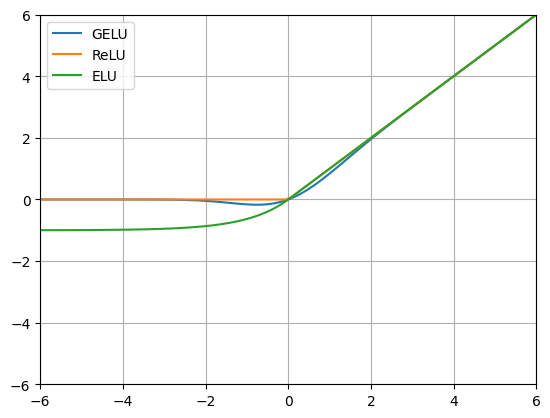

In [33]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
xx = np.linspace(-6, 6, 100)
plt.plot(xx, xx * stats.norm.cdf(xx), label='GELU')
plt.plot(xx, np.where(xx > 0, xx, 0), label='ReLU')
plt.plot(xx, np.where(xx > 0, xx, np.exp(xx) - 1), label='ELU')
plt.grid()
plt.legend()
plt.xlim(-6, 6)
plt.ylim(-6, 6);

<img src="https://i.ibb.co/0sbtpQN/Screenshot-158.png" width="900" height="300">\
[Источник](https://openaccess.thecvf.com/content/ICCV2021W/NeurArch/papers/Yao_Leveraging_Batch_Normalization_for_Vision_Transformers_ICCVW_2021_paper.pdf)

In [5]:
def get_mlp(embedding_dim, hidden_dim, dropout_rate):
    return nn.Sequential(
        # YOUR CODE HERE: Liner + GELU + Dropout + Linear + Dropout
        nn.Linear(embedding_dim, hidden_dim),
        nn.GELU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_dim, embedding_dim),
        nn.Dropout(dropout_rate),
    )
mlp = get_mlp(100, 100*2, 0.1)

In [6]:
nn.LayerNorm?

## Стохастическая глубина (stochastic depth)

<img src="https://i.ibb.co/1q04DSF/Screenshot-151.png" width='150' height='300'>

Стохастическая глубина по сути хитрый дропаут. Дело в том, что если мы будем случайно занулять блок внутри трансформера, но оставлять скип коннекшены, то по сути мы будем уменять глубину сети. Таким образом модель обучается более гибко.

In [7]:
class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if not self.training:
            return x
        # YOUR CODE HERE: generate random tenzor, create mask from it and multiply x by the mask. also divide result by 1 - drop_prob
        shape = (x.shape[0],) + (1,)*(x.ndim - 1)
        mask = (torch.rand(shape) > self.drop_prob).type(x.dtype)
        return x * mask / (1 - self.drop_prob)

## Собираем блок энкодера

In [8]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_hidden_dim, dropout=0.1, attention_dropout=0.1, drop_path_rate=0.1):
        super().__init__()
        self.attention_norm = nn.LayerNorm(embedding_dim)
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=attention_dropout, batch_first=True)
        self.attention_dropout = nn.Dropout(dropout)

        self.mlp_norm = nn.LayerNorm(embedding_dim)
        self.mlp = get_mlp(embedding_dim, mlp_hidden_dim, dropout)
        self.drop_path = DropPath(drop_path_rate) if drop_path_rate > 0 else nn.Identity()

    def forward(self, x):
        x_prime = self.attention_norm(x)
        x_prime = self.attention(x_prime, x_prime, x_prime)[0]
        x_prime = self.attention_dropout(x_prime)
        x = x + self.drop_path(x_prime)

        x_prime = self.mlp_norm(x)
        x_prime = self.mlp(x_prime)
        x = x + self.drop_path(x_prime)
        return x

In [9]:
result.shape

torch.Size([1, 256, 100])

In [10]:
enc = TransformerEncoder(embedding_dim=100, num_heads=10, mlp_hidden_dim=200)
assert enc(result).shape == result.shape

## Позиционные эмбеддинги

In [11]:
n_patches = 16 * 16
embedding_dim = 64

# YOUR CODE HERE
emb = torch.nn.Parameter(torch.empty((n_patches, embedding_dim)))

torch.nn.init.trunc_normal_(emb, std=0.2);

## Class emb

In [12]:
class_emb = torch.nn.Parameter(torch.empty((1, embedding_dim)))
torch.nn.init.trunc_normal_(emb, std=0.2);

## Собираем все вместе в ViT

In [13]:
class ViT(nn.Module):
    def __init__(self, in_h, in_w, n_patches, in_channels, embedding_dim,
                 num_layers, num_heads, mlp_hidden_dim, num_classes=1000,
                 dropout=0.1, attention_dropout=0.1, depth_dropout=0.1):
        super().__init__()
        self.pp = PatchPartitioner(in_h, in_w,
                                   int(n_patches**0.5), int(n_patches**0.5),
                                   in_channels, embedding_dim
                                   )
        self.pos_embeddings = torch.nn.Parameter(torch.empty((1, n_patches, embedding_dim)))
        torch.nn.init.trunc_normal_(self.pos_embeddings, std=0.2)

        self.class_embedding = torch.nn.Parameter(torch.empty((1, 1, embedding_dim)))
        torch.nn.init.trunc_normal_(self.class_embedding, std=0.2)

        depth_dropout_rates = [x.item() for x in torch.linspace(0, depth_dropout, num_layers)]
        self.blocks = nn.Sequential(*[
            TransformerEncoder(embedding_dim, num_heads, mlp_hidden_dim, dropout,
                               attention_dropout, drop_path_rate)
            for drop_path_rate in depth_dropout_rates
        ])
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(embedding_dim)
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        patches = self.pp(x)
        patches = patches + self.pos_embeddings

        x = torch.cat((self.class_embedding.expand(patches.shape[0], 1, -1), patches), dim=1)
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        return self.fc(x[:,0])

In [14]:
batch = torch.rand((16, 3, 224, 224))
vit = ViT(224, 224, 256, 3, 64, 6, 8, 128)
vit(batch).shape

torch.Size([16, 1000])

# Трюки для обучения

## Warm-up и расписание

Популярное расписание lr - cosine learning rate:\
$lr(t)= lr_{min} + \frac{1}{2}(lr_{max}-lr_{min})(1+\cos{( \Large\frac{\pi t}{T}}))$

Плюс часто используется warm-up, который помогает не "убежать" быстро в ошибочном направлении. Warm-up это принцип использование в самом начале очень маленького learnin rate и его быстрого увеличения. Далее можно использовать другие расписания.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://githu

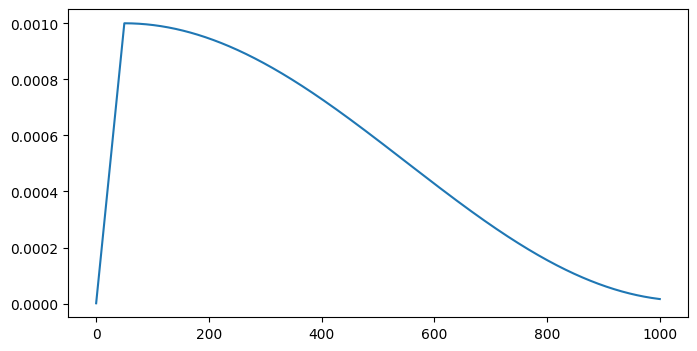

In [76]:
optim = torch.optim.Adam(params=[torch.ones((4, 5))], lr=1e-3)
cosine_sch = torch.optim.lr_scheduler.CosineAnnealingLR(optim, 1000, 1e-5)
warm_up = torch.optim.lr_scheduler.LinearLR(optim, 1e-3, 1, 50)
sch = torch.optim.lr_scheduler.SequentialLR(optim, schedulers=[warm_up, cosine_sch], milestones=[warm_up.total_iters])
lr = [sch.get_last_lr()]
for t in range(1000):
    sch.step()
    lr.append(sch.get_last_lr())
plt.figure(figsize=(8, 4))
plt.plot(lr)
plt.show()

## Аугментация данных

<img src="https://i.ibb.co/YypHjMS/Screenshot-159.png" width="900" height="600">

Для mixup изображение формируется как\
$x = x_1 \lambda + (1 - \lambda) \cdot x_2$\
где $x_1, x_2$ - случайные семплы изображений, $\lambda$ - случайная величина, в оригинале семпл из бета распределения $\mathcal{B}(\alpha, \alpha)$

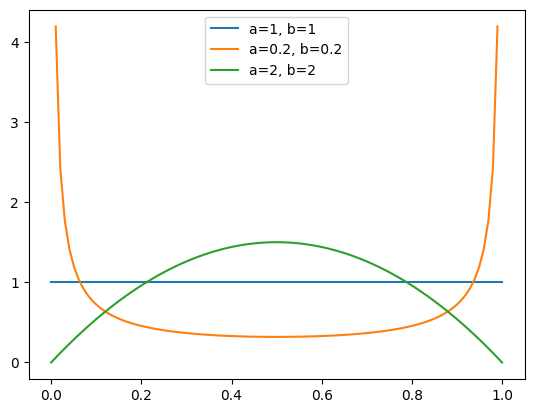

In [89]:
xx = np.linspace(0, 1, 100)
plt.plot(xx, stats.beta.pdf(xx, a=1, b=1), label="a=1, b=1")
plt.plot(xx, stats.beta.pdf(xx, a=0.2, b=0.2), label="a=0.2, b=0.2")
plt.plot(xx, stats.beta.pdf(xx, a=2, b=2), label="a=2, b=2")
plt.legend()
plt.show()